# DCGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/swkim01/DSAC5/blob/main/gg-18-DCGAN.ipynb"><img src="https://github.com/swkim01/DSAC5/raw/main/colab_logo_32px.png" />구글 코랩에서 실행</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/swkim01/DSAC5/blob/main/gg-18-DCGAN.ipynb"><img src="https://github.com/swkim01/DSAC5/raw/main/GitHub-Mark-32px.png" />깃헙에서 소스 보기</a>
  </td>
</table>

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" />

In [1]:
from __future__ import print_function
import itertools
import math
import time

import torch
from torch import optim
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.utils as vutils
import torchvision.transforms as transforms
from IPython import display
from torch.autograd import Variable

''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

nz = 100 # 노이즈 벡터의 크기
nc = 3 # 채널의 수
ngf = 64 # generator 필터 조정
ndf = 64 # discriminator 필터 조정
niter = 10 # 에폭 수
lr = 0.0002
beta1 = 0.5

imageSize = 64 # 만들어지는 이미지의 크기
batchSize = 64 # 미니배치의 크기
outf = "/content/sample_data"

transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),                     
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = dsets.CIFAR10(root='/content/sample_data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batchSize, shuffle=True)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(

            # 입력값은 Z이며 Transposed Convolution을 거칩니다.
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            # (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        output = self.main(input)
        return output

class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # (nc) x 64 x 64)
            nn.Conv2d(nc, ndf, 4,2,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netG = _netG().to(DEVICE)
netG.apply(weights_init)
print(netG)

netD = _netD().to(DEVICE)
netD.apply(weights_init)
print(netD)
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
fixed_noise = Variable(fixed_noise)

label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(100):
    for i, data in enumerate(train_loader):
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)

        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)

        inputv = Variable(input).to(DEVICE)
        labelv = Variable(label).to(DEVICE)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise).to(DEVICE)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label)).to(DEVICE)
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        labelv = Variable(label.fill_(real_label)).to(DEVICE)
        output = netD(fake)

        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if ((i+1) % 100 == 0):
            #print(i, "step")
            fixed_noise = fixed_noise.to(DEVICE)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
            '%s/fake_samples_epoch_%s.png' % (outf, str(epoch)+" "+str(i+1)),
            normalize=True)
    vutils.save_image(real_cpu,
            '%s/real_samples.png' % outf,
            normalize=True)
    fake = netG(fixed_noise)
    vutils.save_image(fake.data,
            '%s/fake_samples_epoch_%s.png' % (outf, epoch),
            normalize=True)
    #result_dict = {"loss_D":loss_D,"loss_G":loss_G,"score_D":score_D,"score_G1":score_G1,"score_G2":score_G2}

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG.pth' % (outf))
    torch.save(netD.state_dict(), '%s/netD.pth' % (outf))




Using PyTorch version: 1.7.0+cu101  Device: cuda


Extracting /content/sample_data/cifar-10-python.tar.gz to /content/sample_data
_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size

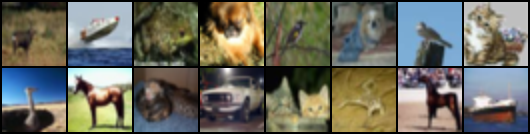

In [ ]:
from IPython.display import Image

Image(filename =outf+'/real_samples.png')

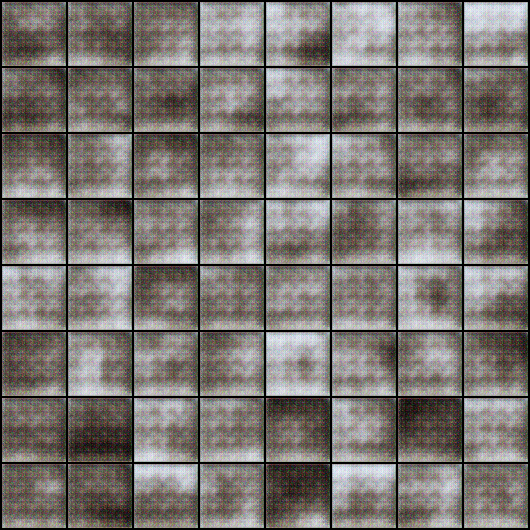

In [ ]:
from IPython.display import Image

Image(filename =outf+'/fake_samples_epoch_0.png')

In [ ]:
from IPython.display import Image

Image(filename =outf+'/fake_samples_epoch_99 100.png')

FileNotFoundError: ignored